In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.layers import Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
import pandas
import numpy as np

In [2]:
# fix random seed for reproducibility
tf.random.set_seed(7)

# Load the data
data = pandas.read_csv('training.csv', usecols=['text', 'author'], sep=',', encoding='ISO-8859-1')
texts = data['text']  # Extract the text column
labels = data['author']-1  # Extract the label column

# Convert the text into numerical sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)


# Pad the sequences to a fixed length
max_sequence_length = 1000  # Set the maximum sequence length
sequences = sequence.pad_sequences(sequences, maxlen=max_sequence_length)


# Encode the labels into one-hot vectors
num_classes = 50  # Set the number of classes
labels = to_categorical(labels, num_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)


# load the dataset but only keep the top n words, zero the rest
top_words = 10001

In [3]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_sequence_length))

model.add(LSTM(200, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(LSTM(200, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.5))

model.add(Dense(50, activation='softmax')) # Output layer with 50 units and softmax activation


In [4]:
def cosine_annealing(epoch, initial_learning_rate, T_max):
    return initial_learning_rate * (1 + np.cos(np.pi * epoch / T_max)) / 2

initial_learning_rate = 0.001
T_max = 50  # Total number of epochs

lr_scheduler = LearningRateScheduler(lambda epoch: cosine_annealing(epoch, initial_learning_rate, T_max))


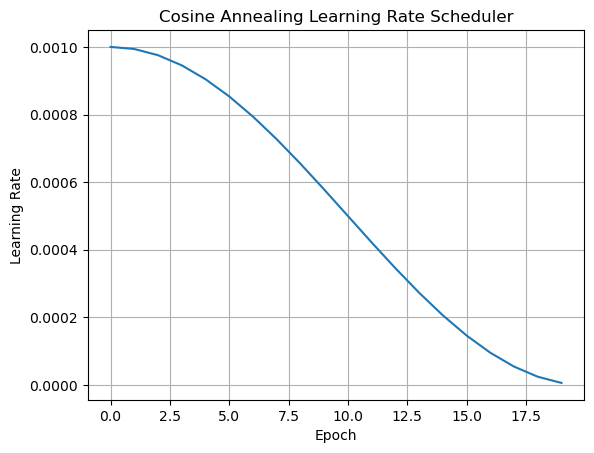

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def cosine_annealing(epoch, initial_learning_rate, T_max):
    return initial_learning_rate * (1 + np.cos(np.pi * epoch / T_max)) / 2

initial_learning_rate = 0.001
T_max = 20  # Total number of epochs

# Generate learning rates for each epoch
epochs = np.arange(T_max)
learning_rates = [cosine_annealing(epoch, initial_learning_rate, T_max) for epoch in epochs]

# Plot the learning rates
plt.plot(epochs, learning_rates)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Cosine Annealing Learning Rate Scheduler")
plt.grid(True)
plt.show()


In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Use categorical_crossentropy loss for multiclass classification
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 32)          320032    
                                                                 
 lstm (LSTM)                 (None, 1000, 200)         186400    
                                                                 
 module_wrapper (ModuleWrapp  (None, 1000, 200)        0         
 er)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 1000, 200)         320800    
                                                                 
 module_wrapper_1 (ModuleWra  (None, 1000, 200)        0         
 pper)                                                           
                                                                 
 lstm_2 (LSTM)               (None, 200)               3

In [7]:
filepath="best_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks=[checkpoint, lr_scheduler])



Epoch 1/20
  39/1342 [..............................] - ETA: 4:10:20 - loss: 3.7069 - accuracy: 0.0897

KeyboardInterrupt: 

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))